__[networkx exploration](https://github.com/apowers313/roc/blob/master/experiments/2024.06.30-08.30.41-networkx-exploration.ipynb)__

In [1]:
!date

Mon Jul 15 05:32:32 PDT 2024


In [79]:
import networkx as nx

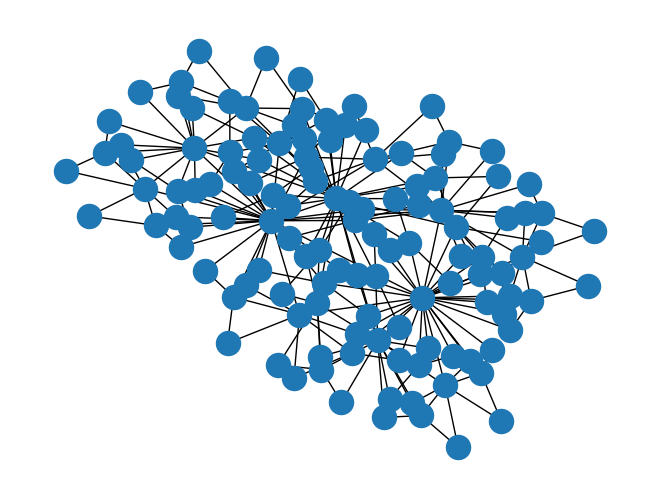

In [28]:
G = nx.dorogovtsev_goltsev_mendes_graph(5)
nx.draw(G)

More graph generators at https://networkx.org/documentation/stable/reference/generators.html

In [29]:
route = nx.shortest_path(G, source=0, target=106)
print(route)

[0, 6, 106]


More graph algorithms at
https://networkx.org/documentation/stable/reference/algorithms/index.html

# Visualizing Routes

The route of the traveller is: [0, 4, 19, 12, 2, 7, 10, 18, 5, 13, 6, 11, 3, 16, 17, 15, 14, 8, 9, 1, 0]
Edge list [(0, 4), (4, 19), (19, 12), (12, 2), (2, 7), (7, 10), (10, 18), (18, 5), (5, 13), (13, 6), (6, 11), (11, 3), (3, 16), (16, 17), (17, 15), (15, 14), (14, 8), (8, 9), (9, 1), (1, 0)]


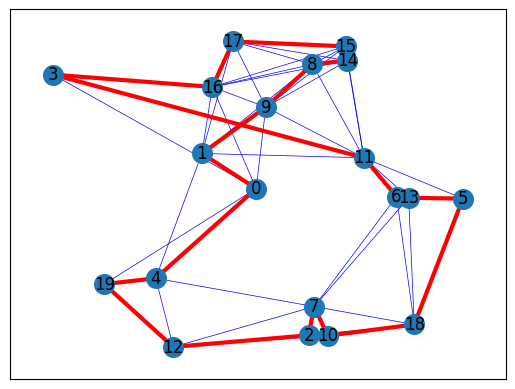

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math

G = nx.random_geometric_graph(20, radius=0.4, seed=3)
pos = nx.get_node_attributes(G, "pos")

# Depot should be at (0,0)
pos[0] = (0.5, 0.5)

H = G.copy()


# Calculating the distances between the nodes as edge's weight.
for i in range(len(pos)):
    for j in range(i + 1, len(pos)):
        dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
        dist = dist
        G.add_edge(i, j, weight=dist)

cycle = nx_app.christofides(G, weight="weight")
edge_list = list(nx.utils.pairwise(cycle))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

# Draw the route
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

print("The route of the traveller is:", cycle)
print("Edge list", edge_list)
plt.show()

route [0, 2, 14, 122]
edge list [(0, 2), (2, 14), (14, 122)]


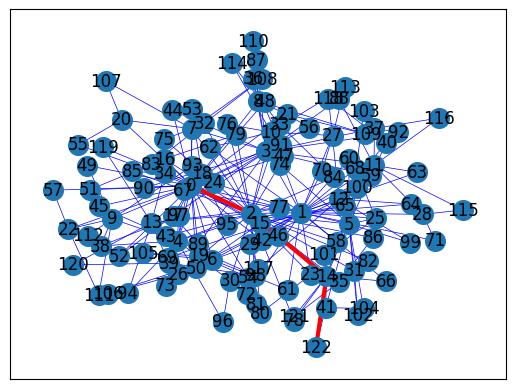

In [91]:
G = nx.dorogovtsev_goltsev_mendes_graph(5)
# pos = nx.bfs_layout(G, start=0)
pos = nx.spring_layout(G, k=5 / math.sqrt(G.order()))

route = nx.shortest_path(G, source=0, target=122)

H = G.copy()

print("route", route)
edge_list = list(nx.utils.pairwise(route))
print("edge list", edge_list)

# nx.draw(G)

nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

# Draw the route
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

# Performance

From https://developer.nvidia.com/blog/accelerating-networkx-on-nvidia-gpus-for-high-performance-graph-analytics/

In [1]:
%pwd

'/home/apowers/Projects/roc/experiments'

In [1]:
###############################################################################
# Run Betweenness Centrality on a large citation graph using NetworkX
import sys
import time

import networkx as nx
import pandas as pd

# k = int(sys.argv[1])
# k = 10

# Dataset from https://snap.stanford.edu/data/cit-Patents.txt.gz
print("Reading dataset into Pandas DataFrame as an edgelist...", flush=True, end="")
pandas_edgelist = pd.read_csv(
    "/home/apowers/Projects/roc/experiments/assets/cit-Patents.txt",
    skiprows=4,
    delimiter="\t",
    names=["src", "dst"],
    dtype={"src": "int32", "dst": "int32"},
)
print("done.", flush=True)
print("Creating Graph from Pandas DataFrame edgelist...", flush=True, end="")
G = nx.from_pandas_edgelist(pandas_edgelist, source="src", target="dst", create_using=nx.DiGraph)
print("done.", flush=True)
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Reading dataset into Pandas DataFrame as an edgelist...done.
Creating Graph from Pandas DataFrame edgelist...done.
Graph: 3774768 nodes, 16518948 edges


In [2]:
import socket
import multiprocessing
import GPUtil


def perftest_backend(k: int, backend: str | None = None):
    print(
        f"Host: '{socket.gethostname()}' ({multiprocessing.cpu_count()} CPU cores, {len(GPUtil.getAvailable())} NVIDIA GPUs)"
    )
    print(f"Running betweenness_centrality on backend '{backend}'...", flush=True, end="")
    st = time.time()
    bc_result = nx.betweenness_centrality(G, k=k, backend=backend)
    print(f"done, BC time with {k=} was: {(time.time() - st):.6f} s")
    # return bc_result

In [3]:
perftest_backend(10)

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 119.849025 s


In [4]:
perftest_backend(10, "parallel")

Host: '6694e5d3b066' (32 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'parallel'...done, BC time with k=10 was: 260.568838 s


In [4]:
!nvidia-smi

Sat Jul 20 14:51:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:3B:00.0 Off |                    0 |
| N/A   39C    P8              10W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
perftest_backend(10, "cugraph")

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...

done, BC time with k=10 was: 17.225529 s


In [7]:
perftest_backend(50)

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=50 was: 590.580445 s


In [6]:
perftest_backend(50, "cugraph")

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=50 was: 16.374063 s


## Performance Records
Host: '77d80cd501c3' (16 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 75.197873 s

Host: '77d80cd501c3' (16 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'parallel'...done, BC time with k=10 was: 189.716060 s

Host: '6694e5d3b066' (32 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 128.229593 s

Host: '6694e5d3b066' (32 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'parallel'...done, BC time with k=10 was: 260.568838 s

Host: 'aca30a2016a9' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 120.149544 s

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=10 was: 18.952439 s

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=50 was: 590.580445 s

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=50 was: 16.374063 s


# Import / Export

In [10]:
!curl -OL http://gephi.org/datasets/diseasome.gexf.zip
!sudo apt install unzip -y
!unzip diseasome.gexf.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   167  100   167    0     0   2016      0 --:--:-- --:--:-- --:--:--  2036
100 56897  100 56897    0     0   207k      0 --:--:-- --:--:-- --:--:--  207k


In [14]:
H = nx.read_gexf("diseasome.gexf", version="1.2draft")
print(f"Graph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

NetworkXError: No <graph> element in GEXF file.

In [16]:
!curl -OL https://gephi.org/datasets/comic-hero-network.gdf.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1006k  100 1006k    0     0  3553k      0 --:--:-- --:--:-- --:--:-- 3557k


In [17]:
!unzip comic-hero-network.gdf.zip

Archive:  comic-hero-network.gdf.zip
  inflating: comic-hero-network.gdf  
   creating: __MACOSX/
  inflating: __MACOSX/._comic-hero-network.gdf  


In [18]:
from networkx_gdf import read_gdf, write_gdf

H = read_gdf("comic-hero-network.gdf")
print(f"Graph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

ModuleNotFoundError: No module named '__version__'

In [19]:
!curl -OL https://gephi.org/datasets/internet_routers-22july06.gml.zip
!unzip internet_routers-22july06.gml.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  326k  100  326k    0     0  1322k      0 --:--:-- --:--:-- --:--:-- 1325k
Archive:  internet_routers-22july06.gml.zip
  inflating: internet_routers-22july06.gml  


In [23]:
H = nx.read_gml("internet_routers-22july06.gml")
print(f"Graph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

Graph: 22963 nodes, 48436 edges


## Export to Gephi

In [21]:
nx.write_gexf(H, "test2.gexf")

In [22]:
nx.write_gml(H, "test2.gml")